# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as display
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [5]:
data = pd.read_csv("./Train_rev1.csv", index_col=None )
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)['FullDescription']

15510     We are seeking a postdoctoral research associa...
126318    We are seeking experienced driver mates for ou...
164485    My NHS Trust based client is looking for an In...
Name: FullDescription, dtype: object

In [6]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
111191,69684058,Internal Account Manager / Sales Executive,Internal Account Manager / Sales Executive in ...,Derby,Derby,full_time,NaN,eRecruit Solutions Ltd,Sales Jobs,23097,23097,careerbuilder.com,10.047502
66714,68714246,Sales Executive,"Our client who offers conferences, seminars an...",Central London / West End London South East,London,NaN,permanent,Adecco Group,Sales Jobs,25000 - 30000 per annum + BENEFITS,27500,totaljobs.com,10.221977
182001,71601169,Senior Quantity Surveyor,A niche cost and project management consultanc...,London South East,South East London,NaN,permanent,Catalyst Executive Search,Trade & Construction Jobs,"From 45,000 to 55,000 per annum Plus car allow...",50000,careerstructure.com,10.819798


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [7]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [0]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [9]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [0]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for col in text_columns:
    for token in data[col]:
      token_counts.update((token.split()))

In [11]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

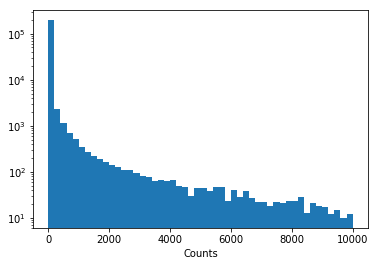

In [12]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [0]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = []
for t in token_counts.most_common():
  if t[1] >= min_count:
    tokens.append(t[0])

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [14]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [0]:
token_to_id = {}
for i in range(len(tokens)):
  token_to_id.update({tokens[i]: i})

In [16]:
len(token_to_id)

34158

In [17]:
len(tokens)

34158

In [18]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [0]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [20]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[ 136  114  269    1    1]
 [ 311  236    1    1    1]
 [ 100 4120  135  388   83]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [21]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [22]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [0]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [24]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[ 143,    8,    5,  141,  288, 1221,   13,  147, 2030,    9],
        [1015, 2449,   17, 3090,  210, 6465, 1015, 2449,   17, 3090],
        [  36,  863,   35, 1931, 9360,   44,   35, 3489,  683,    4]],
       dtype=int32),
 'Log1pSalary': array([10.221977, 10.71444 ,  9.903538], dtype=float32),
 'Title': array([[ 240, 1307,  133,   34,    1,    1,    1,    1,    1,    1],
        [1015, 2449,   17, 3090,  210, 6465,    1,    1,    1,    1],
        [  36,  863,   35, 1931, 9360,   44,   35, 3489,  683,    4]],
       dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]
      
      
class Softmax_pooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        out = torch.sum( x * F.softmax(x, dim=self.dim), dim = self.dim)
        return out

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()  #Softmax_pooling()       
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        #<YOUR CODE>
        h = self.conv1(h)
        h = self.pool1(h)
        h = h.relu()
        h = self.dense(h)
        
        return h#<YOUR CODE>

In [71]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [0]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
#<YOUR CODE HERE>
class descriptionsEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()  #Softmax_pooling()    
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        #<YOUR CODE>
        h = self.conv1(h)
        h = self.pool1(h)
        h = h.relu()
        h = self.dense(h)
        
        return h#<YOUR CODE>

In [73]:
desc_encoder = descriptionsEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = descriptionsEncoder(out_size=64)#<YOUR CODE>
        
        # define layers for categorical features. A few dense layers would do.
        #<YOUR CODE>
        self.layers = nn.Sequential(nn.Linear(n_cat_features, 192),
                                    nn.BatchNorm1d(192),
                                    nn.ReLU(),
                                    #nn.Dropout(0.3),
                                    nn.Linear(192, 132),
                                    nn.BatchNorm1d(132),
                                    nn.ReLU(),
                                    nn.Linear(132, 64))
        
        # define "output" layers that process depend the three encoded vectors into answer
        #<YOUR CODE>
        self.output = nn.Sequential(nn.Linear(192, 64),
                                    nn.BatchNorm1d(64),
                                    nn.ReLU(),
                                    #nn.Dropout(0.3),
                                    nn.Linear(64, 32),
                                    nn.BatchNorm1d(32),
                                    nn.ReLU(),
                                    nn.Linear(32, 1)
                                   )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)#<YOUR CODE>
        
        # apply categorical encoder
        cat_h = self.layers(cat_features) #<YOUR CODE>
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        #<YOUR CODE>
        output = self.output(joint_h)[:, 0]
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output #<YOUR CODE>

In [0]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [101]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
title_encoder.emb.weight 	 torch.Size([34158, 64])
title_encoder.conv1.weight 	 torch.Size([64, 64, 3])
title_encoder.conv1.bias 	 torch.Size([64])
title_encoder.dense.weight 	 torch.Size([64, 64])
title_encoder.dense.bias 	 torch.Size([64])
desc_encoder.emb.weight 	 torch.Size([34158, 64])
desc_encoder.conv1.weight 	 torch.Size([64, 64, 3])
desc_encoder.conv1.bias 	 torch.Size([64])
desc_encoder.dense.weight 	 torch.Size([64, 64])
desc_encoder.dense.bias 	 torch.Size([64])
layers.0.weight 	 torch.Size([192, 3768])
layers.0.bias 	 torch.Size([192])
layers.1.weight 	 torch.Size([192])
layers.1.bias 	 torch.Size([192])
layers.1.running_mean 	 torch.Size([192])
layers.1.running_var 	 torch.Size([192])
layers.1.num_batches_tracked 	 torch.Size([])
layers.3.weight 	 torch.Size([132, 192])
layers.3.bias 	 torch.Size([132])
layers.4.weight 	 torch.Size([132])
layers.4.bias 	 torch.Size([132])
layers.4.running_mean 	 torch.Size([132])
layers.4.running_var 	 torch.Size([132]

In [102]:
print("Optimizer's state_dict:")
for var_name in opt.state_dict():
    print(var_name, "\t", opt.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [139863237340544, 139863237338960, 139863237339392, 139863236949624, 139863237348088, 139863237347152, 139863237345352, 139863237347728, 139863237345568, 139862892294648, 139862892295008, 139862892297312, 139862892294864, 139862892297168, 139862892296232, 139862892297672, 139862892295728, 139862892296880, 139862892295512, 139862892294936, 139862892296952, 139862892295368, 139862892297528, 139863240756248, 139862893091144, 139862893090496, 139862893089128, 139862893092800, 139862900179880, 139862900181104]}]


In [0]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
reference = torch.tensor(batch[target_column], dtype=torch.float32)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [0]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [0]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [0]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [0]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [0]:
train_loss_array = []
val_lost_array = []
mae_train_loss_array = []
mae_val_loss_array = []
i=0
patience = 5
count = 0

Epoch: 38


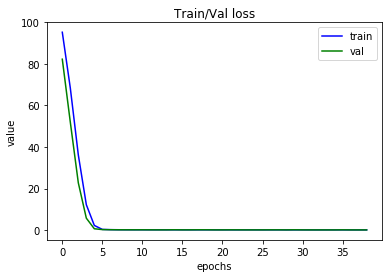

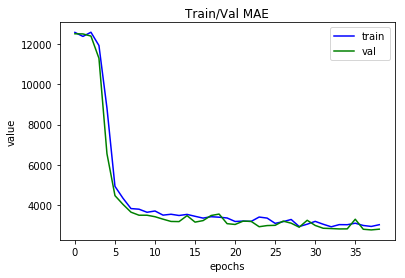

Training:



	Loss:	0.09022
	MAE:	2885.00781



Validation:



	Loss:	0.09693
	MAE:	2976.43799



Early stopping, number of epoch: 39


In [109]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()#[0]
        train_mae += compute_mae(reference, prediction).data.numpy()#[0]
        train_batches += 1
    
    train_loss_array.append(train_loss / train_batches)
    mae_train_loss_array.append(train_mae / train_batches)
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()#[0]
        val_mae += compute_mae(reference, prediction).data.numpy()#[0]
        val_batches += 1

    val_lost_array.append(val_loss / val_batches)
    mae_val_loss_array.append(val_mae / val_batches)
    
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')
    
    if len(val_lost_array) > 2 and val_lost_array[-1] > val_lost_array[-2] > val_lost_array[-3]:
      #if val_lost_array[-1] > val_lost_array[-3]:
        count +=1 
        if count > patience:
          print('Early stopping, number of epoch:', epoch_i)
          break
    
    
    display.clear_output(wait=True)
    
    print('Epoch:', epoch_i)
    
    plt.figure(figsize=(6, 4))
    plt.title("Train/Val loss")
    plt.xlabel("epochs")
    plt.ylabel("value")
    plt.plot(train_loss_array, 'b', label = 'train')
    plt.plot(val_lost_array, 'g', label = 'val')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.title("Train/Val MAE")
    plt.xlabel("epochs")
    plt.ylabel("value")
    plt.plot(mae_train_loss_array, 'b', label = 'train')
    plt.plot(mae_val_loss_array, 'g', label = 'val')
    plt.legend()
    plt.show()
    
    

In [110]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()#[0]
    val_mae += compute_mae(reference, prediction).data.numpy()#[0]
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.09693
	MAE:	2976.43799





### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [0]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    #print('||||||||||||', 'sample = ', sample, '|||||||||||||||||||||||||||||||||')
    sample = dict(sample)
    #print('#############', 'sample = ', sample, '##################################')
    sample_tok = sample[col_name].split()
    
    
#     print('#############################################')
#     s = 
#     print('s = ',s)
    #print('#############################################')
    batch = generate_batch( pd.DataFrame.from_dict(sample, orient = 'index', columns= ['']).transpose() , 1)
    
    #print('ggggggg', 'batch = ', batch, 'ggggggggg')
    
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    
    #print('title_ix  =', title_ix.shape)
#     print('desc_ix =', desc_ix)
    

    
    # compute model prediction on sample (scalar float log-salary)
    baseline_pred =  float(model(title_ix, desc_ix, cat_features))#<YOUR CODE>
    #print('baseline_pred =',   baseline_pred)
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    predictions_without_word = []
    
    if col_name=='Title':
      for i in range(title_ix.shape[1]):
        #print(len(title_ix))
        new_title_ix = title_ix.clone()
        #print(new_title_ix)
        new_title_ix[0][i] = 0
        predictions_without_word.append(float(model(new_title_ix, desc_ix, cat_features)))#<YOUR CODE>
    else:
      for i in range(desc_ix.shape[1]):
        #print(len(title_ix))
        new_title_ix = desc_ix.clone()
        #print(new_title_ix)
        new_title_ix[0][i] = 0
        predictions_without_word.append(float(model(title_ix, new_title_ix, cat_features)))
      
    
    #print('predictions_without_word =',  predictions_without_word)
    score_differences = [
        prediction - baseline_pred for prediction in predictions_without_word
    ]
    
#     # return a list of pairs: [(token, score_difference)]
#     print('z =', sample_tok)
#     print('a = ', score_differences)
    return list(zip(sample_tok, score_differences)) #<YOUR CODE>

In [112]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

Input: Id                                                             72609757
Title                           itu liver nhs staff nurse x **** london
FullDescription       itu liver nhs staff nurse x **** london hcl pe...
LocationRaw                                                South London
LocationNormalized                                    South East London
ContractType                                                        NaN
ContractTime                                                  permanent
Company                                                  HCL Permanent.
Category                                      Healthcare & Nursing Jobs
SalaryRaw                                               25,418 – 33,150
SalaryNormalized                                                  29284
SourceName                                         nursingtimesjobs.com
Log1pSalary                                                     10.2848
Name: 238261, dtype: object
[('itu', -0.15881633758544922

In [0]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [114]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

# predict salary on sample
sample = dict(sample)
batch = generate_batch( pd.DataFrame.from_dict(sample, orient = 'index', columns= ['']).transpose() , 1)
title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
print("Salary (gbp):", float(model(title_ix, desc_ix, cat_features)))

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 53437
Salary (gbp): 9.597573280334473


trainee accounts junior

christopher benn associates are pleased to be involved in the search for a trainee accounts junior for this hungerford based client . you will have a minimum of 6 months experience as an accounts junior and be educated up to a – levels with a passion and motivation to grow your career . following training you will be responsible for preparing accounts for a range of clients , dealing with all aspects of tax and vat . along with extensive training and guidance you will be supported to study either your aat or acca . in addition to this you will also be offered 23 days holiday and a pension plan after 1 years ’ service . should your details be suitable for the role you are responding to , you will be contacted . in the event your details are not suitable , christopher benn associates may retain them and contact you regarding future vacancies . christopher benn associates will not submit your details to a client without your prior knowledge . christopher benn associates is an established consultancy specialising in finance recruitment . we provide a consistently high level of service based upon understanding your requirement and your career objectives . to discuss your next move , forward your cv via this website and one of our qualified consultants will call you . candidates must be eligible to live and work in the uk . please note that we are unable to sponsor visa or work permit applications . please note that due to the high volumes of applications received we are not able to consider applications for candidates that fall outside the criteria specified . this job was originally posted as www . totaljobs . com / jobseeking / traineeaccountsjunior_job ****

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

if say seriously there is my big mistake that i don't read the description of the problems before doing tasks. so i did all tasks like i did in past hw and now i realize that there were some points which i should do in another way. 

A) My first attempt was about just made a Linear layer without anything else (of course with activation function). But this didnt work well , I mean, something gone not in a good way and i just added the Batch Normalization, after that i got a good resuts. 

So, with Batch and 100 epochs I had this values:

Training:

	Loss:	0.07074
	MAE:	2531.75617

Validation:

	Loss:	0.09122
	MAE:	2880.60669
  
  
 Now I try without Batchs.
 
 Training:

	Loss:	0.15405
	MAE:	3748.25324



Validation:

	Loss:	0.18070
	MAE:	4572.26662

As we can see, the result is worse.

Now I implement Dropout.

...and smth goes wrong...

Training:

	Loss:	0.20052
	MAE:	4375.77868



Validation:

	Loss:	0.23632
	MAE:	4417.20889

So, I decide to follow the advice Occamy "simpler solutions are more likely to be correct than complex ones" :))) 

And just stop at Batch's using.

B) I implemented the `Softmax-pooling`. With `GlobalMaxPooling` there a lot of examples how all is work.

`Softmax-pooling` gave such results:

Training:

	Loss:	0.12836
	MAE:	3342.82495



Validation:

	Loss:	0.12557
	MAE:	3241.91597
  
  
  So, `GlobalMaxPooling` is better
  

E) (this version for first implementation: Batchs and only  GlobalMaxPooling )

before the realization of "early stopping" I did 100 epohs, the last epoch gave me: 

Training:

	Loss:	0.07074
	MAE:	2531.75617

Validation:

	Loss:	0.09122
	MAE:	2880.60669
  
 For inspiration i took not [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) but [this](https://github.com/Bjarten/early-stopping-pytorch). I have a constant (`patience`), which i took is equal to 5. The value of `val_loss` function i saved in `val_lost_array`, if new value > then previous value then `count +=1`. When counter is reach the value of patience -- the iterative process is break.
 
 upd. I think that taken a loss function as a criterio of early stopping is not good idea just because on my graphs the behavior of loss function had value about `0.09`.
 
 upd upd. o, it's ok! Instead of 100 epochs I got only 25! 
 
 The value:
 
 Training:

	Loss:	0.11216
	MAE:	3338.08832



Validation:

	Loss:	0.09587
	MAE:	2930.77458
  
  
  The results is worse, but not that much.
 
 


upd. I did more difficult condition (now i comparison not only element and the value before this element but also element that stand out at 2 position) and got such result:  

(38 epochs)

Training:

	Loss:	0.09022
	MAE:	2885.00781


Validation:

	Loss:	0.09693
	MAE:	2976.43799
  
  
  
  So "early stopping" works is well  if  we have difficult the conditions